# **Setup**

In [ ]:
# download data
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nckRRVYRiWG8VWoUY4wwtuQm6DjIbpmo' -O w_review_train.csv

# download font for matplot
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DsfYE5uI1ZA_IXDNkezQTv-NQehxgZQy' -O THSarabun.ttf

# install library
!pip install gensim
!pip install pythainlp

--2023-08-01 17:10:00--  https://docs.google.com/uc?export=download&id=1nckRRVYRiWG8VWoUY4wwtuQm6DjIbpmo
Resolving docs.google.com (docs.google.com)... 173.194.192.101, 173.194.192.102, 173.194.192.100, ...
Connecting to docs.google.com (docs.google.com)|173.194.192.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/16ajdkv01c98oofi2d5i3a6qdn15ffjb/1690909800000/07034668329300256193/*/1nckRRVYRiWG8VWoUY4wwtuQm6DjIbpmo?e=download&uuid=585d265e-ad1b-4b12-97c8-1c89f4748e15 [following]
--2023-08-01 17:10:01--  https://doc-0o-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/16ajdkv01c98oofi2d5i3a6qdn15ffjb/1690909800000/07034668329300256193/*/1nckRRVYRiWG8VWoUY4wwtuQm6DjIbpmo?e=download&uuid=585d265e-ad1b-4b12-97c8-1c89f4748e15
Resolving doc-0o-90-docs.googleusercontent.com (doc-0o-90-docs.googleusercontent.com)... 209.85.200.132, 2607:f

In [ ]:
from gensim.models import Word2Vec

from pythainlp import word_tokenize
from pythainlp.util import dict_trie
from pythainlp.corpus.common import thai_words
from pythainlp.corpus import thai_stopwords

import pandas as pd
import numpy as np
import re

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

%matplotlib inline

# **loading** **data**

In [ ]:
train = pd.read_csv("w_review_train.csv",  encoding='utf8', names=["sentence"])
train.head(10)

,sentence
0,ร้านอาหารใหญ่มากกกกกกก \nเลี้ยวเข้ามาเจอห้องน้...
1,อาหารที่นี่เป็นอาหารจีนแคะที่หากินยากในบ้านเรา...
2,ปอเปี๊ยะสด ทุกวันนี้รู้สึกว่าหากินยาก (ร้านที่...
3,รัานคัพเค้กในเมืองไทยมีไม่มาก หลายๆคนอาจจะสงสั...
4,อร่อย!!! เดินผ่านDigital gatewayทุกวัน ไม่ยักร...
5,ร้านข้าวต้มกระดูกหมู ปากซอยพัฒนาการ 57 เป็นอีก...
6,วันนี้ได้มีโอกาสไปนั่งซดกาแฟที่ร้านวาวี แถวๆอา...
7,สารภาพว่าไม่เคยคิดจะไปต่อคิวซื้อมากินเองครับ บ...
8,เมื่อวันก่อนไปเดินเล่น แบบชิวๆๆ ที่สยามสแควร์แ...
9,วันก่อนไปเดินสยาม หลังจากห่างหายไป ประมาณ 6 เด...


In [ ]:
train.shape

(40000, 1)

# **Creating model and training model using gensim**

In [ ]:
# add word to dict
words = ['ผัดมาม่า', 'ข้าวกะเพราหมู', 'บะหมี่', 'ข้าวผัดมันกุ้ง', 'ข้าวมันไก่', 'ชาไทย', 'โค๊ก', 'ชูโรส', 'ชีสเค๊ก', 'ไอติม']
custom_words_list = set(thai_words())
custom_words_list.update(words)
trie = dict_trie(dict_source=custom_words_list)

In [ ]:
STOP_WORD = list(thai_stopwords()) + [" ", "\n"]

FORMAT = r"[\u0E00-\u0E7Fa-zA-Z'0-9]+"

In [ ]:
def tokenize(sentence):
  return word_tokenize(sentence, engine="newmm", custom_dict=trie)

def cleaning_stop_word(tk_list):
  return [word for word in tk_list if word not in STOP_WORD]

def cleaning_symbols_emoji(tk_list):
  return [re.findall(FORMAT, text)[0] for text in tk_list if re.findall(FORMAT, text)]

**Word2Vec Function:**
* **tokenized_list** เป็นข้อมูลที่ใช้ train โมเดล โดยจะอยู่ในลักษณะของ list ของ list ของ tokens (คำในแต่ละรีวิว)

* **vector_size** เป็นจำนวนมิติของ embedding layer (ขนาดของ embedded  vector) ที่ต้องการ

* **window** คือจำนวนคำใกล้เคียงที่เกิดขึ้นร่วมกันกับคำที่กำลังฝึกฝนอยู่

* **min_count** คือ จำนวนขั้นต่ำของคำที่ปรากฎในข้อมูลการ train ทั้งหมด (คำที่ปรากฎน้อยจะไม่สนใจ)

* **worker** คือจำนวนของ computer threads ที่จะใช้ในการ train

* **sg** คือ ถ้า =0 คือ train ด้วย CBOW, =1 คือ train ด้วย Skip-gram (ปกติ Skip-gram จะใช้เวลา train นานกว่า CBOW)

* **epochs** คือ จำนวนรอบที่โมเดลจะ train ข้อมูล

In [ ]:
# model 1: doesn't clean anything

#### Your Code ####

train['tokenized'] = train['sentence'].astype(str).apply(tokenize)
model_1 = Word2Vec(train['tokenized'], window=5, min_count=1, workers=10, sg=0)

In [ ]:
# model 2: only cleaning stopword

def tk_with_no_stop_word(sentence):
  return cleaning_stop_word( tokenize(sentence) )

#### Your Code ####

train['clean_stop'] = train['sentence'].astype(str).apply(tk_with_no_stop_word)
model_2 = Word2Vec(train['clean_stop'], window=5, min_count=1, workers=10, sg=0)

In [ ]:
# model 3: only cleaning symbols and emoji

def tk_with_no_symbols(sentence):
  return cleaning_symbols_emoji( tokenize(sentence) )

#### Your Code ####

train['clean_sumbols_emoji'] = train['sentence'].astype(str).apply(tk_with_no_symbols)
model_3 = Word2Vec(train['clean_sumbols_emoji'], window=5, min_count=1, workers=10, sg=0)

In [ ]:
# model 4: cleaning stopword, symbols and emoji and more train wongnai to pretrained model

# load pretrained model
model_4 = Word2Vec.load('http://www.arts.chula.ac.th/ling/wp-content/uploads/TNCc5model.bin')

def big_cleaning(sentence):
  return  cleaning_symbols_emoji( cleaning_stop_word( tokenize(sentence) ) )

#### Your Code ####

train['clean_all'] = train['sentence'].astype(str).apply(big_cleaning)

model_4.build_vocab(train['clean_all'], update=True)
model_4.train(train['clean_all'], total_examples=model_4.corpus_count, epochs=10)

(25132769, 29529910)

In [ ]:
# word similarity
print(model_1.wv.similarity('อร่อย', 'สุดยอด'))
print(model_2.wv.similarity('อร่อย', 'สุดยอด'))
print(model_3.wv.similarity('อร่อย', 'สุดยอด'))
print(model_4.wv.similarity('อร่อย', 'สุดยอด'))

0.46884406
0.47055763
0.45742127
0.4896911


In [ ]:
print("doesn't clean anything:" , model_1.wv.most_similar("ชาไทย", topn=5))
print("only cleaning stopword:" , model_2.wv.most_similar("ชาไทย", topn=5))
print("only cleaing symbols and emoji:" , model_3.wv.most_similar("ชาไทย", topn=5))
print("cleaning stopword, symbols and emoji:" , model_4.wv.most_similar("ชาไทย", topn=5))

doesn't clean anything: [('ช็อคโกแลต', 0.8050692677497864), ('นมสด', 0.7989682555198669), ('ช็อกโกแลต', 0.7905741930007935), ('มอคค่า', 0.774276852607727), ('คาราเมล', 0.76663738489151)]
only cleaning stopword: [('คาราเมล', 0.8089638948440552), ('ช๊อกโกแลต', 0.8033187389373779), ('โกโก้', 0.7967572212219238), ('ช็อคโกแลต', 0.7950376868247986), ('ช็อกโกแลต', 0.7938374876976013)]
only cleaing symbols and emoji: [('ช็อกโกแลต', 0.8085980415344238), ('ช๊อกโกแลต', 0.7928184866905212), ('คาราเมล', 0.7895805835723877), ('ช็อคโกแลต', 0.7796087861061096), ('นมสด', 0.7749619483947754)]
cleaning stopword, symbols and emoji: [('เอสเพรสโซ่', 0.7502673864364624), ('คาราเมล', 0.7373428344726562), ('โกโก้', 0.7348647117614746), ('เอสเปรสโซ่', 0.7344227433204651), ('ทีรามิสุ', 0.7331518530845642)]


In [ ]:
print("doesn't clean anything:" , model_1.wv.most_similar("บะหมี่", topn=5))
print("only cleaning stopword:" , model_2.wv.most_similar("บะหมี่", topn=5))
print("only cleaing symbols and emoji:" , model_3.wv.most_similar("บะหมี่", topn=5))
print("cleaning stopword, symbols and emoji:" , model_4.wv.most_similar("บะหมี่", topn=5))

doesn't clean anything: [('หมูแดง', 0.6859369277954102), ('เส้นใหญ่', 0.6859248876571655), ('เย็นตาโฟ', 0.685271680355072), ('ข้าวหน้าเป็ด', 0.6565107107162476), ('เกาเหลา', 0.6479942798614502)]
only cleaning stopword: [('หมูแดง', 0.7279069423675537), ('หยก', 0.7223480939865112), ('ข้าวหมูกรอบ', 0.692918598651886), ('เส้นใหญ่', 0.6819798946380615), ('ข้าวหน้าเป็ด', 0.6710859537124634)]
only cleaing symbols and emoji: [('หมูแดง', 0.7009459137916565), ('เส้นใหญ่', 0.6938351988792419), ('ข้าวหมูแดง', 0.6754563450813293), ('ข้าวหน้าเป็ด', 0.6639280319213867), ('เย็นตาโฟ', 0.6605048179626465)]
cleaning stopword, symbols and emoji: [('หมูแดง', 0.656491219997406), ('ข้าวหมูกรอบ', 0.6439613699913025), ('ข้าวหมูแดง', 0.6371225714683533), ('กระเพาะปลา', 0.6154662370681763), ('เส้นใหญ่', 0.6146404147148132)]


In [ ]:
print("doesn't clean anything:" , model_1.wv.most_similar('ข้าวผัดมันกุ้ง', topn=5))
print("only cleaning stopword:" , model_2.wv.most_similar('ข้าวผัดมันกุ้ง', topn=5))
print("only cleaing symbols and emoji:" , model_3.wv.most_similar('ข้าวผัดมันกุ้ง', topn=5))
print("cleaning stopword, symbols and emoji:" , model_4.wv.most_similar('ข้าวผัดมันกุ้ง', topn=5))

doesn't clean anything: [('3966', 0.7019713521003723), ('BLT', 0.700478732585907), ('loaded', 0.6997314691543579), (',\u200b', 0.6976513266563416), ('soak', 0.6964624524116516)]
only cleaning stopword: [('ฮ่องเต้', 0.6889827251434326), ('Bratwurstl', 0.6853912472724915), ('กุ้งชุบแป้งทอด', 0.6803616881370544), ('เปาะ', 0.673760712146759), ('Tempuraa', 0.6722017526626587)]
only cleaing symbols and emoji: [('หมูแฮม', 0.7202188968658447), ('แบ๋ว', 0.7090221047401428), ('เบื้องญวน', 0.7041757702827454), ('katsu', 0.697800874710083), ('ปูจ๋า', 0.6957934498786926)]
cleaning stopword, symbols and emoji: [('ปูจ๋า', 0.6194885969161987), ('มักกะโรนี', 0.5969683527946472), ('ผัดไทย', 0.5833483338356018), ('ไก้', 0.5455632209777832), ('ยัดไส้', 0.5445750951766968)]


In [ ]:
print("doesn't clean anything:" , model_1.wv.most_similar('ข้าวกะเพราหมู', topn=5))
print("only cleaning stopword:" , model_2.wv.most_similar('ข้าวกะเพราหมู', topn=5))
print("only cleaing symbols and emoji:" , model_3.wv.most_similar('ข้าวกะเพราหมู', topn=5))
print("cleaning stopword, symbols and emoji:" , model_4.wv.most_similar('ข้าวกะเพราหมู', topn=5))

doesn't clean anything: [('ไข่ดาว', 0.6318153738975525), ('ปีกไก่', 0.613277792930603), ('ครึ่งตัว', 0.5581014156341553), ('กุนเชียง', 0.5508122444152832), ('กะเพรา', 0.5479052066802979)]
only cleaning stopword: [('หนังไก่', 0.685713529586792), ('พะแนง', 0.6495660543441772), ('เมี่ยงลาว', 0.6476953029632568), ('ครองตลาด', 0.6148375272750854), ('ไก่กอและ', 0.6139554977416992)]
only cleaing symbols and emoji: [('หมูแฮม', 0.6384360790252686), ('ไก้', 0.6291618347167969), ('อู๊ย', 0.6210561394691467), ('พะแนง', 0.6011908650398254), ('ปลาท่องโก๋', 0.6001861095428467)]
cleaning stopword, symbols and emoji: [('กะเพรา', 0.594687819480896), ('ไข่น้ำ', 0.5776475667953491), ('ผัดกะเพรา', 0.5748775005340576), ('ไข่ดาว', 0.5680506229400635), ('ซี่โครงหมูทอด', 0.5515285730361938)]


# **Visualization**


In [ ]:
plt.style.use("seaborn-notebook")

# setup font for matplotlib
thai_sarabun = FontProperties(fname="THSarabun.ttf", size=18)

<ipython-input-108-2386682631fc>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-notebook")


In [ ]:
# using PCA

def display_plot(words):
  models = [model_1, model_2, model_3, model_4]
  fig, axes = plt.subplots(2, 2, figsize=(14, 14))

  j, k = 0, 0

  for modelx in models:
      if k == 2:
        k = 0
        j = 1

      word_vectors = np.array( [ modelx.wv[w] for w in words ])

      twodim = PCA().fit_transform(word_vectors)[:,:2]

      axes[j][k].scatter(twodim[:,0], twodim[:,1], c='salmon')
      for word, (x,y) in zip(words, twodim):
        axes[j][k].text(x+0.05, y+0.05, word, fontproperties=thai_sarabun)

      k += 1

  axes[0][0].set_title("Model 1: doesn't clean anything")
  axes[0][1].set_title("Model 2: only cleaning stopword")
  axes[1][0].set_title("Model 3: only cleaing symbols and emoji")
  axes[1][1].set_title("Model 4: cleaning stopword, symbols and emoji")


In [ ]:
words = ['ผัดมาม่า', 'ข้าวกะเพราหมู', 'บะหมี่', 'ข้าวผัดมันกุ้ง', 'ข้าวมันไก่', 'ชาไทย', 'โค๊ก', 'ชูโรส', 'ชีสเค๊ก', 'ไอติม']

### Your Code ###



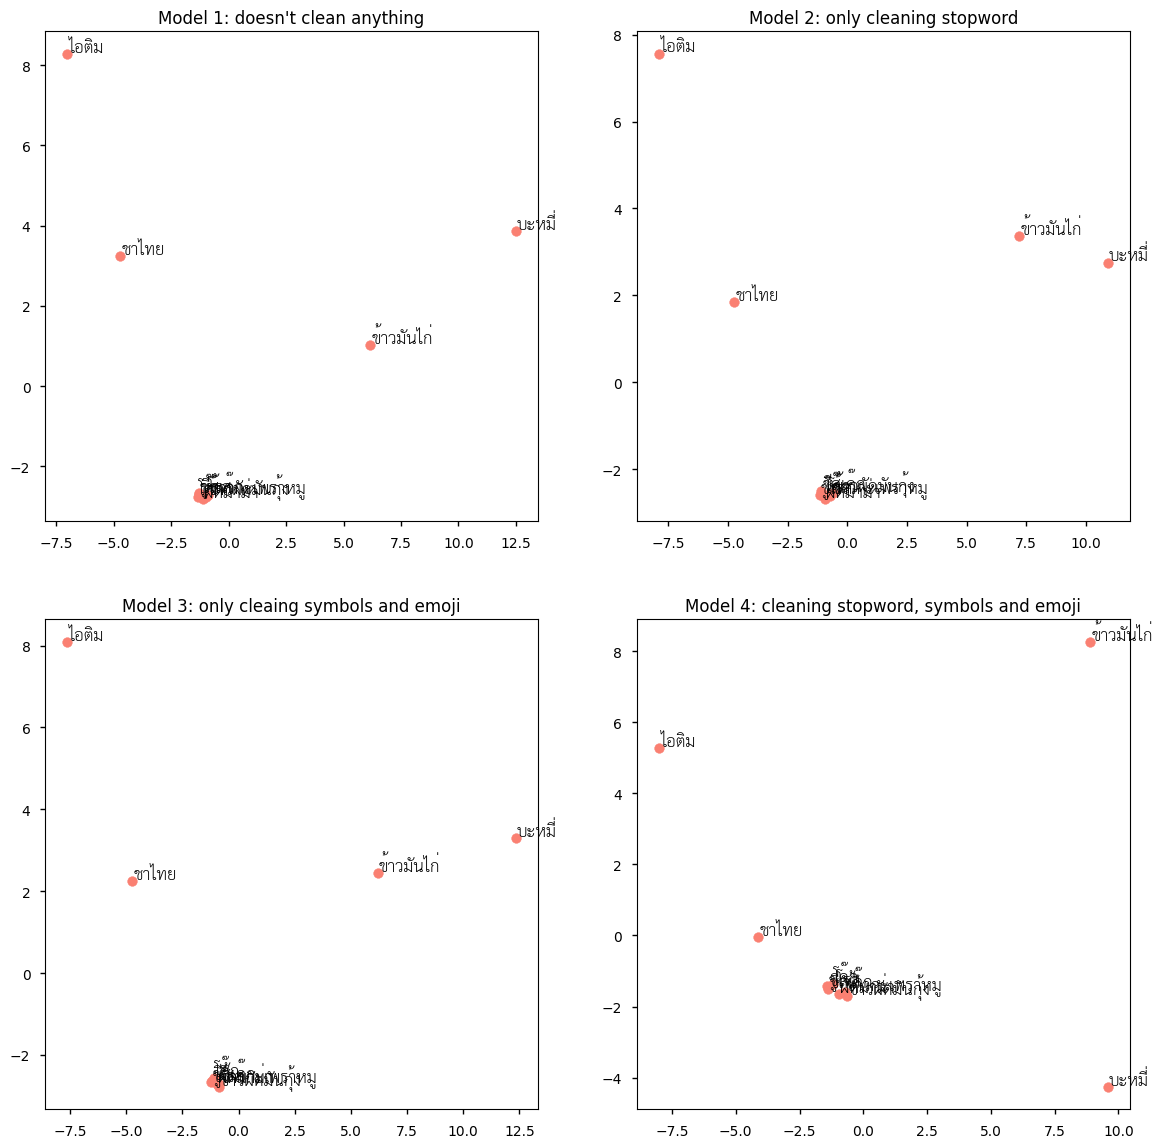

In [ ]:
display_plot(words)